# 2D wave equation, direct problem
---

Consider the 2d wave
$$
u_{tt} = c^2(u_{xx} + u_{yy}), \ (x, y, t) \in [0, 1]\times [0, 1]\times [0, 1] 
$$
with ic
$$
u(x, y, 0) = J_0(\lambda_4 \sqrt{x^2+y^2}), \ \frac{\partial u}{\partial t}(x, y, 0) = 0,
$$
and bc
$$
u = 0.
$$

The analytic solution:
$$
u(x, y, t) = J_0(\lambda_4\sqrt{x^2+y^2})\cos(c\lambda_4 t),
$$
where $J_0$ is the Bessel function of the first kind, and $\lambda_4$ is its $4^{th}$ root.

--

Target: $c = 0.25$.

In [1]:
NAME = "2_inverse_problem"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *

from collections import namedtuple

In [3]:
def siren_layer_params(key, scale, m, n):
	w_key, b_key = random.split(key)
	return random.uniform(w_key, (m, n), jnp.float32, minval = -scale, maxval = scale), jnp.zeros((n, ), jnp.float32)

def init_siren_params(key, layers, c0, w0):
	keys = random.split(key, len(layers))
	return [siren_layer_params(keys[0], w0*jnp.sqrt(c0/layers[0]), layers[0], layers[1])] + \
			[siren_layer_params(k, jnp.sqrt(c0/m), m, n) for m, n, k in zip(layers[1:-1], layers[2:], keys[1:])]

layers = [3, 32, 32, 32, 32, 32, 32, 32, 32, 32, 1] # (x, z, t) -> p
c0 = 1.0
w0 = 5.0
lambda_0 = 1e-10
direct_params = init_siren_params(random.PRNGKey(0), layers, c0, w0)

@jax.jit
def scalar_direct_model(params, x, z, t):
	x_ = jnp.hstack([x, z, t])
	for w, b in params[:-1]:
		x_ = jnp.sin(jnp.dot(x_, w) + b)
	return jnp.sum(jnp.dot(x_, params[-1][0]) + params[-1][1])

direct_model = jax.jit(jax.vmap(scalar_direct_model, in_axes = (None, 0, 0, 0)))
c = jnp.array([1.0])
params = [direct_params, c]

<IPython.core.display.Javascript object>


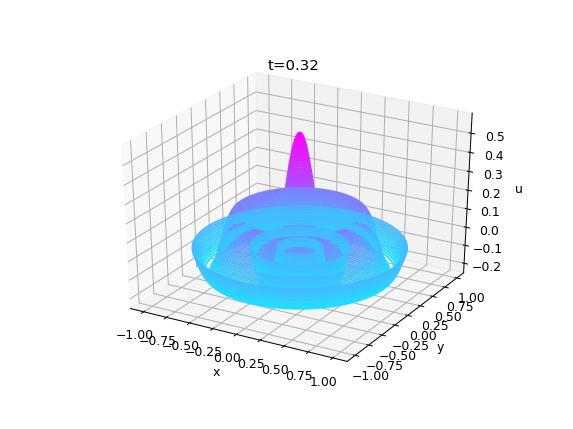

/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [4]:
from scipy.special import j0, jn_zeros

c_true = 0.25
lambda4 = jn_zeros(0, 4)[-1]
u_fn = lambda x, y, t: np.select([x**2+y**2 > 1, x**2+y**2 <= 1], 
								 [0, j0(lambda4*np.sqrt(x**2+y**2))*np.cos(c_true*lambda4*t)])

x0 = np.linspace(-1, 1, 200)
y0 = np.linspace(-1, 1, 200)
t0 = 0.32
u0 = u_fn(x0, y0, t0)

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(x0, y0)
U = u_fn(X, Y, t0)
ax.contour3D(X, Y, U, 100, cmap='cool')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
ax.set_title("t={}".format(t0))

plt.show()

In [5]:
@jax.jit
def mse(pred, true):
	return jnp.mean(jnp.square(pred - true))

@jax.jit
def l2_regularization(params, lambda_0):
	res = 0
	for p in params:
		res += jnp.sum(jnp.square(p[0]))
	return res*lambda_0

@jax.jit
def scalar_du_dx(params, x, y, t):
    return jnp.sum(jax.grad(scalar_direct_model, 1)(params, x, y, t))

@jax.jit
def scalar_du_dy(params, x, y, t):
    return jnp.sum(jax.grad(scalar_direct_model, 2)(params, x, y, t))

@jax.jit
def scalar_du_dt(params, x, y, t):
    return jnp.sum(jax.grad(scalar_direct_model, 3)(params, x, y, t))

du_dt = jax.jit(jax.vmap(scalar_du_dt, in_axes = (None, 0, 0, 0)))

@jax.jit
def du_dxx(params, x, y, t):
    return jax.grad(scalar_du_dx, 1)(params, x, y, t)

@jax.jit
def du_dyy(params, x, y, t):
    return jax.grad(scalar_du_dy, 2)(params, x, y, t)

@jax.jit
def du_dtt(params, x, y, t):
    return jax.grad(scalar_du_dt, 3)(params, x, y, t)

@jax.jit
def loss_fn_(params, batch):
	direct_params, c = params
	collocation, dirichlet, neumann = batch["collocation"], batch["dirichlet"], batch["neumann"]
    
	du_dt_ = du_dt(direct_params, neumann.x, neumann.y, neumann.t)
	
	du_dtt_ = du_dtt(direct_params, collocation.x, collocation.y, collocation.t)
	du_dxx_ = du_dxx(direct_params, collocation.x, collocation.y, collocation.t)
	du_dyy_ = du_dyy(direct_params, collocation.x, collocation.y, collocation.t)
	u_pred = direct_model(direct_params, dirichlet.x, dirichlet.y, dirichlet.t).reshape((-1, 1))
	
	loss_c = mse(du_dtt_ - c**2*(du_dxx_ + du_dyy_), 0)
	loss_d = mse(u_pred, dirichlet.u)
	loss_n = mse(du_dt_, neumann.v)
	return loss_c, loss_d, loss_n

@jax.jit
def loss_fn(params, batch):
	loss_c, loss_d, loss_n = loss_fn_(params, batch)
	return batch["weights"]["c"]*loss_c + batch["weights"]["d"]*loss_d + batch["weights"]["n"]*loss_n + l2_regularization(params[0], lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	loss_c, loss_d, loss_n = loss_fn_(params, batch)
	return batch["weights"]["c"]*loss_c + batch["weights"]["d"]*loss_d + batch["weights"]["n"]*loss_n, loss_c, loss_d, loss_n

In [6]:
key = random.PRNGKey(1)
T_max = 1

# data samples
key, *subkeys = random.split(key, 4)
n_d = 20000
r_d = random.uniform(subkeys[0], (n_d, 1), np.float32, minval = 0, maxval = 1.0)
theta_d = random.uniform(subkeys[1], (n_d, 1), np.float32, minval = 0, maxval = 2*np.pi)
t_d = random.uniform(subkeys[2], (n_d, 1), np.float32, minval = 0, maxval = T_max)
x_d = r_d*jnp.cos(theta_d)
y_d = r_d*jnp.sin(theta_d)
u_d = u_fn(x_d, y_d, t_d)

# ic
key, *subkeys = random.split(key, 4)
n_i = 20000
r_i = random.uniform(subkeys[0], (n_i, 1), np.float32, minval = 0, maxval = 1.0)
theta_i = random.uniform(subkeys[1], (n_i, 1), np.float32, minval = 0, maxval = 2*np.pi)
t_i = jnp.zeros_like(r_i)
x_i = r_i*jnp.cos(theta_i)
y_i = r_i*jnp.sin(theta_i)
u_i = u_fn(x_i, y_i, t_i)
v_i = jnp.zeros_like(r_i)

# bc
key, *subkeys = random.split(key, 4)
n_b = 20000
theta_b = random.uniform(subkeys[1], (n_b, 1), np.float32, minval = 0, maxval = 2*np.pi)
r_b = jnp.ones_like(theta_b)
t_b = random.uniform(subkeys[2], (n_b, 1), np.float32, minval = 0, maxval = T_max)
x_b = r_b*jnp.cos(theta_b)
y_b = r_b*jnp.sin(theta_b)
u_b = u_fn(x_b, y_b, t_b)

# c
key, *subkeys = random.split(key, 4)
n_c = 100000
r_c = random.uniform(subkeys[0], (n_c, 1), np.float32, minval = 0, maxval = 1.0)
theta_c = random.uniform(subkeys[1], (n_c, 1), np.float32, minval = 0, maxval = 2*np.pi)
t_c = random.uniform(subkeys[2], (n_c, 1), np.float32, minval = 0, maxval = T_max)
x_c = r_c*jnp.cos(theta_c)
y_c = r_c*jnp.sin(theta_c)

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "y", "t", "u"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "y", "t"])
dataset_Neumann = namedtuple("dataset_Neumann", ["x", "y", "t", "v"])
dirichlet = dataset_Dirichlet(*map(lambda x: jnp.array(x), [jnp.vstack([x_d, x_i, x_b]), 
															jnp.vstack([y_d, y_i, y_b]),
															jnp.vstack([t_d, t_i, t_b]),
															jnp.vstack([u_d, u_i, u_b])]))
collocation = dataset_Collocation(*map(lambda x: jnp.array(x), [jnp.vstack([x_c, dirichlet.x]),
																jnp.vstack([y_c, dirichlet.y]), 
																jnp.vstack([t_c, dirichlet.t])]))
neumann = dataset_Neumann(*map(lambda x: jnp.array(x), [x_i, y_i, t_i, v_i]))

class Batch_Generator:
	def __init__(self, key, dataset, batch_size):
		self.key = key
		self.dataset = dataset
		self.batch_size = batch_size
		self.index = jnp.arange(dataset[0].shape[0])
		self.pointer = 0
		self._shuffle()
		
	def _shuffle(self):
		key, subkey = random.split(self.key)
		self.index = random.permutation(subkey, jnp.arange(self.dataset[0].shape[0]))
		self.key = key
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self.pointer >= len(self.index):
			self._shuffle()
			self.pointer = 0
		self.pointer += self.batch_size
		index_ = self.index[self.pointer-self.batch_size:self.pointer]
		return [d[index_, :] for d in self.dataset]

In [7]:
lr = 1e-3
start_iteration = 0
iterations = 50000
print_every = 200
save_every = 50000
batch_size_collocation = 10000
batch_size_dirichlet = 10000
batch_size_neumann = 10000
w_c = 1.0
w_d = 100.0
w_n = 10.0

key, *subkeys = random.split(key, 4)

Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size_dirichlet)
Collocation = Batch_Generator(subkeys[1], collocation, batch_size_collocation)
Neumann = Batch_Generator(subkeys[2], neumann, batch_size_neumann)

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
for iteration in range(start_iteration+1, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"neumann": dataset_Neumann(*next(Neumann)),
		"weights": {"c": w_c, "d": w_d, "n": w_n}
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "n"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		print("c = {:.4e}".format(params_[1][0]))
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/07/30, 16:21:53, Iteration: 200, Train Loss: 5.4158e+00, c: 7.8220e-02, d: 5.3203e-02, n: 1.7232e-03
c = 7.5677e-01
2020/07/30, 16:21:57, Iteration: 400, Train Loss: 3.6600e+00, c: 2.7988e-01, d: 3.3200e-02, n: 6.0060e-03
c = 4.3729e-01
2020/07/30, 16:22:01, Iteration: 600, Train Loss: 1.4316e+00, c: 1.6718e-01, d: 1.2287e-02, n: 3.5742e-03
c = 2.3541e-01
2020/07/30, 16:22:05, Iteration: 800, Train Loss: 1.1021e+00, c: 1.1316e-01, d: 9.5211e-03, n: 3.6800e-03
c = 2.2798e-01
2020/07/30, 16:22:10, Iteration: 1000, Train Loss: 8.2533e-01, c: 1.0493e-01, d: 6.8835e-03, n: 3.2047e-03
c = 2.3054e-01
2020/07/30, 16:22:14, Iteration: 1200, Train Loss: 7.9494e-01, c: 8.6748e-02, d: 6.7716e-03, n: 3.1032e-03
c = 2.3318e-01
2020/07/30, 16:22:18, Iteration: 1400, Train Loss: 7.0426e-01, c: 8.6636e-02, d: 5.7798e-03, n: 3.9642e-03
c = 2.3552e-01
2020/07/30, 16:22:22, Iteration: 1600, Train Loss: 5.5431e-01, c: 8.4915e-02, d: 4.2303e-03, n: 4.6362e-03
c = 2.3678e-01
2020/07/30, 16:22:26, Iterat

2020/07/30, 16:27:00, Iteration: 13800, Train Loss: 2.5133e-02, c: 1.0799e-02, d: 1.1554e-04, n: 2.7805e-04
c = 2.4722e-01
2020/07/30, 16:27:05, Iteration: 14000, Train Loss: 1.9975e-02, c: 1.0640e-02, d: 6.6654e-05, n: 2.6697e-04
c = 2.4705e-01
2020/07/30, 16:27:10, Iteration: 14200, Train Loss: 1.9988e-02, c: 1.0599e-02, d: 6.7771e-05, n: 2.6117e-04
c = 2.4735e-01
2020/07/30, 16:27:14, Iteration: 14400, Train Loss: 1.9306e-02, c: 1.0628e-02, d: 6.1686e-05, n: 2.5101e-04
c = 2.4731e-01
2020/07/30, 16:27:19, Iteration: 14600, Train Loss: 1.1027e-01, c: 1.0425e-02, d: 9.6319e-04, n: 3.5235e-04
c = 2.4745e-01
2020/07/30, 16:27:23, Iteration: 14800, Train Loss: 2.6052e-02, c: 9.9978e-03, d: 1.3537e-04, n: 2.5174e-04
c = 2.4718e-01
2020/07/30, 16:27:28, Iteration: 15000, Train Loss: 1.6769e-02, c: 9.2594e-03, d: 5.0984e-05, n: 2.4115e-04
c = 2.4745e-01
2020/07/30, 16:27:33, Iteration: 15200, Train Loss: 1.1517e-01, c: 9.5310e-03, d: 1.0257e-03, n: 3.0680e-04
c = 2.4766e-01
2020/07/30, 16:2

2020/07/30, 16:32:04, Iteration: 27200, Train Loss: 1.4108e-02, c: 2.9634e-03, d: 1.0373e-04, n: 7.7160e-05
c = 2.4939e-01
2020/07/30, 16:32:08, Iteration: 27400, Train Loss: 7.6919e-03, c: 3.0512e-03, d: 3.9245e-05, n: 7.1621e-05
c = 2.4925e-01
2020/07/30, 16:32:13, Iteration: 27600, Train Loss: 5.6087e-03, c: 2.9352e-03, d: 2.0165e-05, n: 6.5694e-05
c = 2.4930e-01
2020/07/30, 16:32:17, Iteration: 27800, Train Loss: 6.8073e-03, c: 2.8358e-03, d: 3.3937e-05, n: 5.7778e-05
c = 2.4921e-01
2020/07/30, 16:32:22, Iteration: 28000, Train Loss: 1.3378e-02, c: 3.5915e-03, d: 8.1798e-05, n: 1.6072e-04
c = 2.4913e-01
2020/07/30, 16:32:26, Iteration: 28200, Train Loss: 1.7627e-02, c: 2.7015e-03, d: 1.4051e-04, n: 8.7489e-05
c = 2.4929e-01
2020/07/30, 16:32:31, Iteration: 28400, Train Loss: 5.5690e-03, c: 2.8024e-03, d: 2.2017e-05, n: 5.6484e-05
c = 2.4931e-01
2020/07/30, 16:32:35, Iteration: 28600, Train Loss: 4.7820e-03, c: 2.5729e-03, d: 1.6806e-05, n: 5.2853e-05
c = 2.4931e-01
2020/07/30, 16:3

2020/07/30, 16:37:06, Iteration: 40600, Train Loss: 3.0503e-03, c: 1.3621e-03, d: 1.3267e-05, n: 3.6148e-05
c = 2.4965e-01
2020/07/30, 16:37:11, Iteration: 40800, Train Loss: 4.4944e-03, c: 1.7358e-03, d: 2.3301e-05, n: 4.2845e-05
c = 2.4964e-01
2020/07/30, 16:37:15, Iteration: 41000, Train Loss: 4.8901e-03, c: 1.7741e-03, d: 2.3926e-05, n: 7.2341e-05
c = 2.4960e-01
2020/07/30, 16:37:20, Iteration: 41200, Train Loss: 4.4908e-03, c: 1.2183e-03, d: 2.9875e-05, n: 2.8494e-05
c = 2.4968e-01
2020/07/30, 16:37:24, Iteration: 41400, Train Loss: 7.7843e-03, c: 1.3822e-03, d: 5.5361e-05, n: 8.6596e-05
c = 2.4966e-01
2020/07/30, 16:37:29, Iteration: 41600, Train Loss: 2.8257e-03, c: 1.2006e-03, d: 1.2827e-05, n: 3.4240e-05
c = 2.4963e-01
2020/07/30, 16:37:33, Iteration: 41800, Train Loss: 2.3203e-03, c: 1.1382e-03, d: 9.1417e-06, n: 2.6795e-05
c = 2.4972e-01
2020/07/30, 16:37:38, Iteration: 42000, Train Loss: 2.1851e-03, c: 1.1936e-03, d: 7.3909e-06, n: 2.5244e-05
c = 2.4971e-01
2020/07/30, 16:3

In [ ]:
t_index = 0
txy_test = tensor_grid([t_c[t_index], x_c, y_c])
u_pred = direct_model(direct_params, txy_test[:, 1:2], txy_test[:, 2:3], txy_test[:, 0:1]).reshape((n_c, n_c))
u_true = u_fn(txy_test[:, 1:2], txy_test[:, 2:3], txy_test[:, 0:1]).reshape((n_c, n_c))

import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

cmap = cool
norm = Normalize(vmin=0, vmax=0.5)

X, Y = np.meshgrid(x_c, y_c)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, Y, u_true, cmap = cmap, norm = norm, levels = 1000)
ax[0].set_title("true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

# norm = mpl.colors.Normalize(vmin=1.0, vmax=3.0)
im1 = ax[1].contourf(X, Y, u_pred, cmap = cmap, norm = norm, levels = 1000)
ax[1].set_title("pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
im2 = ax[2].contourf(X, Y, u_true - u_pred, cmap = cmap, norm = norm, levels = 1000)
ax[2].set_title("t = {:.4e}, MSE: {}".format(t_c[t_index], np.mean(np.square(u_true - u_pred))))
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()